In [1]:
# general tools
import sys
from glob import glob

# data tools
import time
import h5py
import random
import numpy as np
from random import shuffle

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# deep learning tools
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
tf.config.run_functions_eagerly(True)

# from keras_unet_collection import models as k_models
from keras_unet_collection import utils as k_utils
# from keras_unet_collection import layer_utils as k_layers
# from keras_unet_collection.activations import GELU

2022-09-12 10:00:00.860791: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1


In [3]:
sys.path.insert(0, '/glade/u/home/ksha/NCAR/')
sys.path.insert(0, '/glade/u/home/ksha/NCAR/libs/')

from namelist import *
import data_utils as du
import graph_utils as gu
import convnext_keras as ck

from sklearn.metrics import classification_report, auc, roc_curve
from sklearn.metrics import confusion_matrix

import matplotlib.pyplot as plt
%matplotlib inline



In [4]:
from importlib import reload
reload(ck)

<module 'convnext_keras' from '/glade/u/home/ksha/NCAR/libs/convnext_keras.py'>

In [5]:
L_vars = 19

In [27]:
filename_neg_train = sorted(glob("/glade/scratch/ksha/DATA/NCAR_batch/TRAIN*neg_neg_neg*.npy"))
filename_pos_train = sorted(glob("/glade/scratch/ksha/DATA/NCAR_batch/TRAIN*pos*.npy"))

In [7]:
filename_neg_valid = sorted(glob("/glade/scratch/ksha/DATA/NCAR_batch/VALID*neg_neg_neg*.npy"))
filename_pos_valid_pnn = sorted(glob("/glade/scratch/ksha/DATA/NCAR_batch/VALID*pos_neg_neg*.npy"))
filename_pos_valid_npn = sorted(glob("/glade/scratch/ksha/DATA/NCAR_batch/VALID*neg_pos_neg*.npy"))
filename_pos_valid_nnp = sorted(glob("/glade/scratch/ksha/DATA/NCAR_batch/VALID*neg_neg_pos*.npy"))

filename_pos_valid_ppn = sorted(glob("/glade/scratch/ksha/DATA/NCAR_batch/VALID*pos_pos_neg*.npy"))
filename_pos_valid_pnp = sorted(glob("/glade/scratch/ksha/DATA/NCAR_batch/VALID*pos_neg_pos*.npy"))
filename_pos_valid_npp = sorted(glob("/glade/scratch/ksha/DATA/NCAR_batch/VALID*neg_pos_pos*.npy"))

filename_pos_valid_ppp = sorted(glob("/glade/scratch/ksha/DATA/NCAR_batch/VALID*pos_pos_pos*.npy"))

In [8]:
filename_valid = filename_neg_valid[::100] + \
        filename_pos_valid_pnn + \
        filename_pos_valid_npn[::20] + \
        filename_pos_valid_nnp[::20] + \
        filename_pos_valid_ppn + \
        filename_pos_valid_pnp + \
        filename_pos_valid_npp + \
        filename_pos_valid_ppp

In [9]:
len(filename_valid)

7406

In [10]:
L_valid = len(filename_valid)
L_var = 19

TEST_input = np.empty((L_valid, 128, 128, L_var))
TEST_target = np.ones((L_valid, 3))

for i, name in enumerate(filename_valid):
    
    TEST_input[i, ...] = np.load(name)
    
    if 'pos_neg_neg' in name:
        TEST_target[i, 0] = 1.0
        TEST_target[i, 1] = 0.0
        TEST_target[i, 2] = 0.0
    elif 'neg_pos_neg' in name:
        TEST_target[i, 0] = 0.0
        TEST_target[i, 1] = 1.0
        TEST_target[i, 2] = 0.0
    elif 'neg_neg_pos' in name:
        TEST_target[i, 0] = 0.0
        TEST_target[i, 1] = 0.0
        TEST_target[i, 2] = 1.0
    elif 'pos_pos_neg' in name:
        TEST_target[i, 0] = 1.0
        TEST_target[i, 1] = 1.0
        TEST_target[i, 2] = 0.0
    elif 'pos_neg_pos' in name:
        TEST_target[i, 0] = 1.0
        TEST_target[i, 1] = 0.0
        TEST_target[i, 2] = 1.0
    elif 'neg_pos_pos' in name:
        TEST_target[i, 0] = 0.0
        TEST_target[i, 1] = 1.0
        TEST_target[i, 2] = 1.0
    elif 'pos_pos_pos' in name:
        TEST_target[i, 0] = 1.0
        TEST_target[i, 1] = 1.0
        TEST_target[i, 2] = 1.0
    else:
        TEST_target[i, :] = 0.0

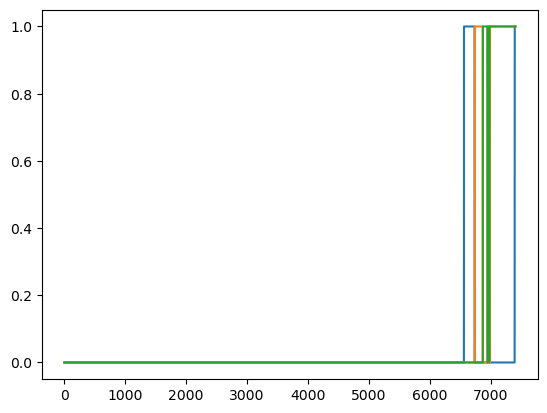

In [11]:
plt.plot(TEST_target[:, 0])
plt.plot(TEST_target[:, 1])
plt.plot(TEST_target[:, 2])

**ConvNext**

In [12]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import backend
from tensorflow.keras import layers
from tensorflow.keras import utils
from tensorflow.keras import Model

  
class LayerScale(layers.Layer):
    """Layer scale module.
    References:
      - https://arxiv.org/abs/2103.17239
    Args:
      init_values (float): Initial value for layer scale. Should be within
        [0, 1].
      projection_dim (int): Projection dimensionality.
    Returns:
      Tensor multiplied to the scale.
    """

    def __init__(self, init_values, projection_dim, **kwargs):
        super().__init__(**kwargs)
        self.init_values = init_values
        self.projection_dim = projection_dim

    def build(self, input_shape):
        self.gamma = tf.Variable(
            self.init_values * tf.ones((self.projection_dim,))
        )

    def call(self, x):
        return x * self.gamma

    def get_config(self):
        config = super().get_config()
        config.update(
            {
                "init_values": self.init_values,
                "projection_dim": self.projection_dim,
            }
        )
        return config
    


def Head(num_classes=1000, name=None):
    """Implementation of classification head of RegNet.
    Args:
      num_classes: number of classes for Dense layer
      name: name prefix
    Returns:
      Classification head function.
    """
    if name is None:
        name = str(backend.get_uid("head"))

    def apply(x):
        x = layers.GlobalAveragePooling2D(name=name + "_head_gap")(x)
        x = layers.LayerNormalization(
            epsilon=1e-6, name=name + "_head_layernorm"
        )(x)
        x = layers.Dense(num_classes, name=name + "_head_dense")(x)
        return x

    return apply


In [13]:
MODEL_CONFIGS = {
    "tiny": {
        "depths": [3, 3, 9, 3],
        "projection_dims": [96, 192, 384, 768],
    },
    "small": {
        "depths": [3, 3, 27, 3],
        "projection_dims": [96, 192, 384, 768],
    },
    "base": {
        "depths": [3, 3, 27, 3],
        "projection_dims": [128, 256, 512, 1024],
    },
    "large": {
        "depths": [3, 3, 27, 3],
        "projection_dims": [192, 384, 768, 1536],
    },
    "xlarge": {
        "depths": [3, 3, 27, 3],
        "projection_dims": [256, 512, 1024, 2048],
    },
}

In [14]:
depths=[3, 3, 27, 3]
projection_dims=[96, 192, 384, 768]
drop_path_rate=0.0
layer_scale_init_value=1e-6
model_name='test'
input_shape=(128, 128, 19)
classes=3

IN = layers.Input(shape=input_shape)
X = IN

num_convnext_blocks = 4

# ----- convnext block 0 ----- #

X = layers.Conv2D(projection_dims[0], kernel_size=4, strides=4, name="{}_down0".format(model_name))(X)
X = layers.LayerNormalization(epsilon=1e-6, name="{}_down0_norm".format(model_name))(X)

for j in range(depths[0]):
    
    X_convnext = X
    X_convnext = layers.Conv2D(filters=projection_dims[0], kernel_size=7, padding="same",
                               groups=projection_dims[0], name="{}_down0_dconv{}".format(model_name, j))(X_convnext)
    X_convnext = layers.LayerNormalization(epsilon=1e-6, name="{}_down0_dconv{}_norm".format(model_name, j))(X_convnext)
    X_convnext = layers.Dense(4 * projection_dims[0], name="{}_down0_dense{}_p1".format(model_name, j))(X_convnext)
    X_convnext = layers.Activation("gelu", name="{}_down0_gelu{}".format(model_name, j))(X_convnext)
    X_convnext = layers.Dense(projection_dims[0], name="{}_down0_dense{}_p2".format(model_name, j))(X_convnext)

    X_convnext = LayerScale(layer_scale_init_value, projection_dims[0], name="{}_down0_layerscale{}".format(model_name, j))(X_convnext)

    X = X + X_convnext


# ----- convnext block 1 ----- #

X = layers.LayerNormalization(epsilon=1e-6, name="{}_down1_norm".format(model_name))(X)
X = layers.Conv2D(projection_dims[1], kernel_size=2, strides=2, name="{}_down1".format(model_name))(X)

for j in range(depths[1]):
    
    X_convnext = X
    X_convnext = layers.Conv2D(filters=projection_dims[1], kernel_size=7, padding="same",
                               groups=projection_dims[1], name="{}_down1_dconv{}".format(model_name, j))(X_convnext)
    X_convnext = layers.LayerNormalization(epsilon=1e-6, name="{}_down1_dconv{}_norm".format(model_name, j))(X_convnext)
    X_convnext = layers.Dense(4 * projection_dims[1], name="{}_down1_dense{}_p1".format(model_name, j))(X_convnext)
    X_convnext = layers.Activation("gelu", name="{}_down1_gelu{}".format(model_name, j))(X_convnext)
    X_convnext = layers.Dense(projection_dims[1], name="{}_down1_dense{}_p2".format(model_name, j))(X_convnext)

    X_convnext = LayerScale(layer_scale_init_value, projection_dims[1], name="{}_down1_layerscale{}".format(model_name, j))(X_convnext)

    X = X + X_convnext

# ----- convnext block 2 ----- #

X = layers.LayerNormalization(epsilon=1e-6, name="{}_down2_norm".format(model_name))(X)
X = layers.Conv2D(projection_dims[2], kernel_size=2, strides=2, name="{}_down2".format(model_name))(X)

for j in range(depths[2]):
    
    X_convnext = X
    X_convnext = layers.Conv2D(filters=projection_dims[2], kernel_size=7, padding="same",
                               groups=projection_dims[2], name="{}_down2_dconv{}".format(model_name, j))(X_convnext)
    X_convnext = layers.LayerNormalization(epsilon=1e-6, name="{}_down2_dconv{}_norm".format(model_name, j))(X_convnext)
    X_convnext = layers.Dense(4 * projection_dims[2], name="{}_down2_dense{}_p1".format(model_name, j))(X_convnext)
    X_convnext = layers.Activation("gelu", name="{}_down2_gelu{}".format(model_name, j))(X_convnext)
    X_convnext = layers.Dense(projection_dims[2], name="{}_down2_dense{}_p2".format(model_name, j))(X_convnext)

    X_convnext = LayerScale(layer_scale_init_value, projection_dims[2], name="{}_down2_layerscale{}".format(model_name, j))(X_convnext)

    X = X + X_convnext

# ----- convnext block 3 ----- #

X = layers.LayerNormalization(epsilon=1e-6, name="{}_down3_norm".format(model_name))(X)
X = layers.Conv2D(projection_dims[3], kernel_size=2, strides=1, name="{}_down3".format(model_name))(X)

for j in range(depths[3]):
    
    X_convnext = X
    X_convnext = layers.Conv2D(filters=projection_dims[3], kernel_size=7, padding="same",
                               groups=projection_dims[3], name="{}_down3_dconv{}".format(model_name, j))(X_convnext)
    X_convnext = layers.LayerNormalization(epsilon=1e-6, name="{}_down3_dconv{}_norm".format(model_name, j))(X_convnext)
    X_convnext = layers.Dense(4 * projection_dims[3], name="{}_down3_dense{}_p1".format(model_name, j))(X_convnext)
    X_convnext = layers.Activation("gelu", name="{}_down3_gelu{}".format(model_name, j))(X_convnext)
    X_convnext = layers.Dense(projection_dims[3], name="{}_down3_dense{}_p2".format(model_name, j))(X_convnext)

    X_convnext = LayerScale(layer_scale_init_value, projection_dims[3], name="{}_down3_layerscale{}".format(model_name, j))(X_convnext)

    X = X + X_convnext

OUT = X

OUT = layers.GlobalMaxPooling2D(name="{}_head_pool".format(model_name))(OUT)
OUT = layers.LayerNormalization(epsilon=1e-6, name="{}_head_norm".format(model_name))(OUT)
OUT = layers.Dense(classes, name="{}_head_out".format(model_name))(OUT)

model = Model(inputs=IN, outputs=OUT, name=model_name)

2022-09-12 10:04:25.410725: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2022-09-12 10:04:26.568175: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2022-09-12 10:04:26.677699: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:89:00.0 name: Tesla V100-SXM2-32GB computeCapability: 7.0
coreClock: 1.53GHz coreCount: 80 deviceMemorySize: 31.75GiB deviceMemoryBandwidth: 836.37GiB/s
2022-09-12 10:04:26.678418: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
2022-09-12 10:04:26.916759: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.10
2022-09-12 10:04:26.917759: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublasLt.so.10
2

In [22]:
def verif_metric(VALID_target, Y_pred, thres=0.5):

    tn, fp, fn, tp = confusion_matrix(VALID_target[:, 0].ravel(), Y_pred[:, 0].ravel()>thres).ravel()

    CSI1 = tp/(tp+fn+fp)
    CSI_metric1 = 1 - CSI1
    
    tn, fp, fn, tp = confusion_matrix(VALID_target[:, 1].ravel(), Y_pred[:, 1].ravel()>thres).ravel()

    CSI2 = tp/(tp+fn+fp)
    CSI_metric2 = 1 - CSI2

    tn, fp, fn, tp = confusion_matrix(VALID_target[:, 2].ravel(), Y_pred[:, 2].ravel()>thres).ravel()

    CSI3 = tp/(tp+fn+fp)
    CSI_metric3 = 1 - CSI3
    
    print('{} {} {}'.format(CSI1, CSI2, CSI3))
    metric = (CSI_metric1 + CSI_metric2 + CSI_metric3)/3.0


    return metric

In [16]:
tol = 0
min_del = 0
max_tol = 500 # early stopping with patience

epochs = 500
L_train = 64
batch_size = 100

batch_size_half = 50

valid_size = 1

In [17]:
batch_dir = '/glade/scratch/ksha/DATA/NCAR_batch/'
temp_dir = '/glade/work/ksha/NCAR/Keras_models/'

key = 'NEW_3C'

model_name = '{}_pp19'.format(key)
model_path = temp_dir+model_name

W_new = model.get_weights()
W_old = k_utils.dummy_loader(temp_dir+'NEW_S_pp19_tune3')

for l in range(len(W_new)):
    if W_new[l].shape ==  W_old[l].shape:
        W_new[l] = W_old[l]

model.set_weights(W_new)


In [18]:
model.compile(loss=keras.losses.mean_absolute_error, optimizer=keras.optimizers.SGD(lr=1e-5))

In [19]:
# X_batch_sparse = np.empty((batch_size, 128, 128, L_sparse))*np.nan
# X_batch_dense = np.empty((batch_size, 128, 128, L_dense))*np.nan
X_batch = np.empty((batch_size, 128, 128, L_vars))
Y_batch = np.empty((batch_size, 3))
X_batch[...] = np.nan
Y_batch[...] = np.nan

In [20]:
Y_pred = model.predict([TEST_input,])

/glade/work/ksha/anaconda3/lib/python3.9/site-packages/tensorflow/python/data/ops/dataset_ops.py:3503: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  warnings.warn(
2022-09-12 10:07:55.241008: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2022-09-12 10:07:55.247745: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 2600000000 Hz
2022-09-12 10:07:55.991397: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudnn.so.7
2022-09-12 10:08:02.463511: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.10


In [23]:
Y_pred[Y_pred<0] = 0
Y_pred[Y_pred>1] = 1
record = verif_metric(TEST_target, Y_pred, thres=0.5)
print("Initial record: {}".format(record))

0.03188180404354588 0.07844990548204159 0.0681879557115852
Initial record: 0.9404934449209424


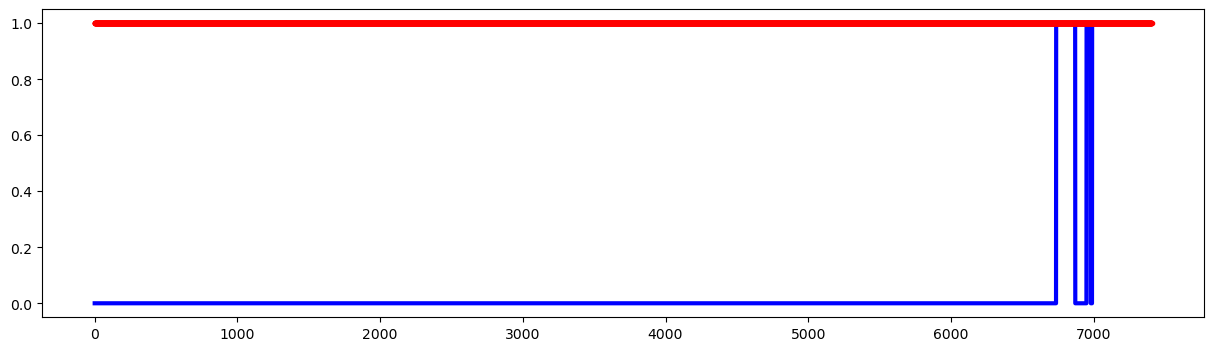

In [24]:
plt.figure(figsize=(15, 4))
plt.plot(TEST_target[:, 1], 'b-', lw=3.0)
plt.plot(Y_pred[:, 1], 'r.')
#plt.plot(Y_pred>0.5)

In [25]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [ ]:
# ========== Training loop ========== #

N_aug = int(np.random.uniform(1, 5))
N_storm = 100 - N_aug

L_storm = len(filename_neg_train)
L_aug = len(filename_pos_train)

for i in range(epochs):
    
    shuffle(filename_neg_train)
    shuffle(filename_pos_train)
    
    #print('epoch = {}'.format(i))
    start_time = time.time()
    
    # loop of batch
    for j in range(L_train):
        
        ind_storm = du.shuffle_ind(L_storm)
        ind_aug = du.shuffle_ind(L_aug)
        
        file_pick_storm = []
        for ind_temp in ind_storm[:N_storm]:
            file_pick_storm.append(filename_neg_train[ind_temp])

        file_pick_aug = []
        for ind_temp in ind_aug[:N_aug]:
            file_pick_aug.append(filename_pos_train[ind_temp])
        
        file_pick = file_pick_storm + file_pick_aug #file_pick_calm + 
        
        if len(file_pick) != 100:
            sregwet
        
        for k in range(batch_size):
            name = file_pick[k]
            data = np.load(name)
            
            X_batch[k, ...] = data
            
            if 'pos_neg_neg' in name:
                Y_batch[k, 0] = np.random.uniform(0.65, 0.95)
                Y_batch[k, 1] = np.random.uniform(0.01, 0.1)
                Y_batch[k, 2] = np.random.uniform(0.01, 0.1)
            elif 'neg_pos_neg' in name:
                Y_batch[k, 0] = np.random.uniform(0.01, 0.1)
                Y_batch[k, 1] = np.random.uniform(0.65, 0.95)
                Y_batch[k, 2] = np.random.uniform(0.01, 0.1)
            elif 'neg_neg_pos' in name:
                Y_batch[k, 0] = np.random.uniform(0.01, 0.1)
                Y_batch[k, 1] = np.random.uniform(0.01, 0.1)
                Y_batch[k, 2] = np.random.uniform(0.65, 0.95)
            elif 'pos_pos_neg' in name:
                Y_batch[k, 0] = np.random.uniform(0.65, 0.95)
                Y_batch[k, 1] = np.random.uniform(0.65, 0.95)
                Y_batch[k, 2] = np.random.uniform(0.01, 0.1)
            elif 'pos_neg_pos' in name:
                Y_batch[k, 0] = np.random.uniform(0.65, 0.95)
                Y_batch[k, 1] = np.random.uniform(0.01, 0.1)
                Y_batch[k, 2] = np.random.uniform(0.65, 0.95)
            elif 'neg_pos_pos' in name:
                Y_batch[k, 0] = np.random.uniform(0.01, 0.1)
                Y_batch[k, 1] = np.random.uniform(0.65, 0.95)
                Y_batch[k, 2] = np.random.uniform(0.65, 0.95)
            elif 'pos_pos_pos' in name:
                Y_batch[k, 0] = np.random.uniform(0.65, 0.95)
                Y_batch[k, 1] = np.random.uniform(0.65, 0.95)
                Y_batch[k, 2] = np.random.uniform(0.65, 0.95)
            else:
                Y_batch[k, :] = np.random.uniform(0.01, 0.1)
                
        #Y_batch_cate = tf.keras.utils.to_categorical(Y_batch)
        
        # # add noise within sparse inputs
        # for v in flag_sparse:
        #     X_batch[..., v] += np.random.uniform(0, 0.01, size=(batch_size, 128, 128))

        # shuffle indices
        ind_ = du.shuffle_ind(batch_size)
        X_batch = X_batch[ind_, ...]
        Y_batch = Y_batch[ind_, :]
        
        if np.sum(np.isnan(X_batch)) > 0:
            asfeargagqarew
        
        # train on batch
        model.train_on_batch([X_batch,], [Y_batch,]);
    
    # epoch end operations
    Y_pred = model.predict([TEST_input,])
    Y_pred[Y_pred<0] = 0
    Y_pred[Y_pred>1] = 1
    #Y_pred = Y_pred[:, -1]
    
    # plt.figure()
    # plt.plot(TEST_target)
    # plt.plot(Y_pred)
    
    record_temp = verif_metric(TEST_target, Y_pred, thres=0.5)
    
    # if i % 10 == 0:
    #     model.save(model_path_backup)
    
    if (record - record_temp > min_del) and (np.max(Y_pred) > 0.6):
        print('Validation loss improved from {} to {}'.format(record, record_temp))
        record = record_temp
        tol = 0
        #print('tol: {}'.format(tol))
        # save
        print('save to: {}'.format(model_path))
        model.save(model_path)
    else:
        print('Validation loss {} NOT improved'.format(record_temp))
        tol += 1
        #print('tol: {}'.format(tol))
        if tol >= max_tol:
            print('Early stopping')
            sys.exit();
        else:
            #print('Pass to the next epoch')
            continue;
    print("--- %s seconds ---" % (time.time() - start_time))

/glade/work/ksha/anaconda3/lib/python3.9/site-packages/tensorflow/python/data/ops/dataset_ops.py:3503: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  warnings.warn(


0.03188180404354588 0.07844990548204159 0.06820637493246894
Validation loss improved from 0.9404934449209424 to 0.9404873051806478
save to: /glade/work/ksha/NCAR/Keras_models/NEW_3C_pp19


2022-09-12 10:19:07.454918: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: /glade/work/ksha/NCAR/Keras_models/NEW_3C_pp19/assets
--- 466.9847116470337 seconds ---


/glade/work/ksha/anaconda3/lib/python3.9/site-packages/tensorflow/python/data/ops/dataset_ops.py:3503: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  warnings.warn(


0.031736154324828875 0.07844990548204159 0.06953693665789067
Validation loss improved from 0.9404873051806478 to 0.9400923345117462
save to: /glade/work/ksha/NCAR/Keras_models/NEW_3C_pp19
INFO:tensorflow:Assets written to: /glade/work/ksha/NCAR/Keras_models/NEW_3C_pp19/assets
--- 475.659556388855 seconds ---


/glade/work/ksha/anaconda3/lib/python3.9/site-packages/tensorflow/python/data/ops/dataset_ops.py:3503: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  warnings.warn(


0.031113876789047916 0.07844990548204159 0.06980367715799314
Validation loss 0.9402108468569725 NOT improved
